<a id='top'></a>

# Academic Mastery Study

## THE DATA
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data).
```python
category_labels.csv
test.csv
training.csv
valid_test.csv
valid_training.csv
```
Test data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding *users who answered at least 6 questions*, taking **one** of their answers (uniformly random, *from their 6th question to their last*), and inserting it into the **test set**.
* Any *later answers by this user* are removed, 
* and any *earlier answers are included in the **training set***.  
* All answers *from users not in the test set are also used for the training set* (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

[Grockit/kaggle] have attempted to provide a reasonable validation split on the **training set** by taking the previous correct/incorrect answer for each of the students in the **test set**, for those users who had at least one previous answer.  
* The results are in the additional files `valid_training.csv` and `valid_test.csv`. 
* Participants may find it helpful to compare potential algorithms by training on the `valid_training.csv` file and computing their performance on the `valid_test.csv` files.  However, there is no guarantee that this is an optimal validation set.

---

**`correct`: `0` or `1` [TARGET] - indicates whether the student answered the question correctly.**

---
**`user_id`**: [[**categorical**]](#user_id) - anonymized numeric identifier for the user answering the question.

    1. How many users are there?   
    2. Distribution of questions per user?
    3. Distribution of correct/incorrect questions per user?
    4. Ratio - correct/(correct + incorrect) - per user?  
---       
**`question_id`**: [[**categorical**]](#question_id) - a numeric identifier for the question being answered.

    1. How many unique questions are there?
    2. How many of them are correct and incorrect?
    3. Distribution of users per question?
---       
**`question_type`**: [[**categorical**]](#question_type) - a numeric code representing the type of question; either `MultipleChoiceOneCorrect` (`0`) for multiple choice, or `SPR` (`1`) for free response questions.

    1. Frequency and distribution of these two categories?
---    
**`group_name`**: [[**categorical**]](#group_name) - a numeric code representing the group of the question `{'act':0, 'gmat':1, 'sat':2}`.

    1. Frequency and distribution of these categories?
---

`group_name`

     track_name   
        
        subtrack_name
    
            tag_string


---
**`track_name`**: [[**categorical**]](#track_name) - the numeric code for the track within the test this question is associated with (mappings from category fields to numeric values are in `category_labels.csv`).

    1. Frequency and distribution of these categories?
---
**`subtrack_name`**: [[**categorical**]](#subtrack_name) - the numeric code for the subtrack within the track this question is associated with (mappings from category fields to numeric values are in category_labels.csv).

---
**`tag_string`**: [[**categorical**]](#tag_string) - a space-separated list of tag ids this question has been tagged with (mappings from category fields to numeric values are in category_labels.csv).

---
**`round_started_at`**: [[**numeric**]](#round_started_at) [use this as reference date] - a UTC timestamp indicating when the user saw the question.

---
**`answered_at`**: [[**numeric**]](#answered_at) [minutes from reference date] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

    1. What is the number of NULLs and the % of the total?
---
**`deactivated_at`**: [[**numeric**]](#deactivated_at) [minutes from reference date] - a UTC timestamp indicating when the round finished, either because of being answered or timing out.

    1. Are there any NULLs?
---
**`game_type`**: [[**categorical**]](#game_type) - indicates the type of game/study session (mappings from category fields to numeric values are in category_labels.csv).

---
**`num_players`**: [[**numeric**]](#num_players) - the number of players in the game at the time (multiple people can be viewing the same question simultaneously).

    1. Distribution of number of players per question?
---
**`date_of_test`**: [[**numeric**]](#date_of_test) [minutes from reference date] - the date the user entered as their expected test date (if entered).

    1. How many NULLs and % of the total?
---  
**For all categorical features: how many categories are there?**

**For numeric features: mean, std, median?**

**For all ration of missing data (NULLs %)?**

---

## INITIAL EXPLORATION

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### training.csv
#### Info, Missing &amp; Useless Data
---

In [2]:
df = pd.read_csv('../data/raw/training.csv', parse_dates=True) # https://www.kaggle.com/c/WhatDoYouKnow/data
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 14 columns):
correct             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
game_type           int64
num_players         int64
date_of_test        object
dtypes: int64(9), object(5)
memory usage: 518.2+ MB


In [3]:
df.head() 

,correct,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,date_of_test
0,0,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,7,1,NaN
1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,7,1,NaN
2,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,7,1,NaN
3,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,7,1,NaN
4,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,7,1,NaN


In [4]:
df_by_user_start = df.set_index(['user_id', 'round_started_at']).sort_index()
df_by_user_start.info()
df_by_user_start.head() 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851475 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 12 columns):
correct           int64
question_id       int64
question_type     int64
group_name        int64
track_name        int64
subtrack_name     int64
tag_string        object
answered_at       object
deactivated_at    object
game_type         int64
num_players       int64
date_of_test      object
dtypes: int64(8), object(4)
memory usage: 514.6+ MB


correct  question_id  question_type  group_name  \
user_id round_started_at                                                       
0       2011-08-26 16:54:31        1         5937              0           0   
        2011-08-26 16:56:12        1          294              0           0   
        2011-08-26 16:56:39        0         5625              0           0   
        2011-08-26 16:57:05        1         4322              0           0   
        2011-08-26 16:57:29        1         5024              0           0   

                             track_name  subtrack_name       tag_string  \
user_id round_started_at                                                  
0       2011-08-26 16:54:31           2             10   17 122 171 206   
        2011-08-26 16:56:12           2             10    0 100 171 206   
        2011-08-26 16:56:39           2             10   40 124 171 206   
        2011-08-26 16:57:05           2             10   18 139 171 206   
        2011-08-26 16:57:29           2             10  104 127 171 206   

                                     answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   

                             game_type  num_players date_of_test  
user_id round_started_at                                          
0       2011-08-26 16:54:31          7            1          NaN  
        2011-08-26 16:56:12          7            1          NaN  
        2011-08-26 16:56:39          7            1          NaN  
        2011-08-26 16:57:05          7            1          NaN  
        2011-08-26 16:57:29          7            1          NaN

In [5]:
df_by_user_start = df_by_user_start[['answered_at', 'deactivated_at', 'correct', 'group_name', 'track_name', 'subtrack_name', 'tag_string', 'question_id', 'question_type', 'game_type', 'num_players', 'date_of_test']]
df_by_user_start.head()

answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   

                             correct  group_name  track_name  subtrack_name  \
user_id round_started_at                                                      
0       2011-08-26 16:54:31        1           0           2             10   
        2011-08-26 16:56:12        1           0           2             10   
        2011-08-26 16:56:39        0           0           2             10   
        2011-08-26 16:57:05        1           0           2             10   
        2011-08-26 16:57:29        1           0           2             10   

                                  tag_string  question_id  question_type  \
user_id round_started_at                                                   
0       2011-08-26 16:54:31   17 122 171 206         5937              0   
        2011-08-26 16:56:12    0 100 171 206          294              0   
        2011-08-26 16:56:39   40 124 171 206         5625              0   
        2011-08-26 16:57:05   18 139 171 206         4322              0   
        2011-08-26 16:57:29  104 127 171 206         5024              0   

                             game_type  num_players date_of_test  
user_id round_started_at                                          
0       2011-08-26 16:54:31          7            1          NaN  
        2011-08-26 16:56:12          7            1          NaN  
        2011-08-26 16:56:39          7            1          NaN  
        2011-08-26 16:57:05          7            1          NaN  
        2011-08-26 16:57:29          7            1          NaN

In [6]:
df_by_user_start.isnull().sum()

answered_at        556018
deactivated_at         30
correct                 0
group_name              0
track_name              0
subtrack_name           0
tag_string              0
question_id             0
question_type           0
game_type               0
num_players             0
date_of_test      3824208
dtype: int64

<a id='user_id' href='#top'>back to menu</a>

### user_id
---

1. How many users are there?   
2. Distribution of questions per user?
3. Distribution of correct/incorrect questions per user?
4. Ratio - correct/(correct + incorrect) - per user? 

In [7]:
userid_count = len(df['user_id'].unique())
print(('Number of users:'), (userid_count))

Number of users: 179106


In [8]:
by_userid = df.groupby('user_id')

question_count = by_userid['correct'].count()
correct_answer_count = by_userid['correct'].sum()
incorrect_answer_count = question_count.subtract(correct_answer_count)
ratio = correct_answer_count/question_count

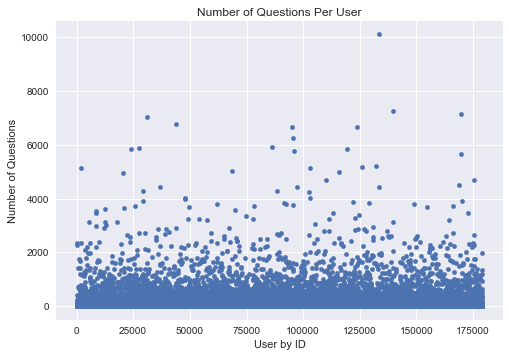

In [9]:
df_question_count = pd.DataFrame({'User by ID':question_count.index, 'Number of Questions':question_count.values})
# print(question_count)

df_question_count.plot(kind='scatter', x='User by ID', y='Number of Questions')
plt.title('Number of Questions Per User')
# plt.ylim(0,2000)
plt.show() 

In [10]:
user_score = {
    'num_questions': question_count,
    'num_correct': correct_answer_count,
    'num_incorrect': incorrect_answer_count,
    'correct_ratio': ratio
}
df_user_score = pd.DataFrame(user_score)
df_user_score = df_user_score[['num_questions', 'num_correct', 'num_incorrect', 'correct_ratio']]
df_user_score.head() 

,num_questions,num_correct,num_incorrect,correct_ratio
user_id,,,,
0,7,5,2,0.714286
1,14,6,8,0.428571
2,8,2,6,0.250000
3,7,3,4,0.428571
4,11,7,4,0.636364


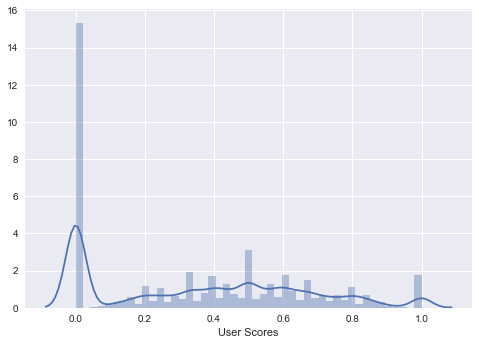

In [11]:
sns.distplot(df_user_score.correct_ratio, axlabel='User Scores')
plt.show()

<a id='question_id' href='#top'>back to menu</a>

### question_id
---

1. How many unique questions are there?
2. How many of them are correct and incorrect?
3. Distribution of users per question?

In [12]:
print(('Question Observations:'), (len(df_by_user_start['question_id'])))
print(('Unique Questions:'), (len( df_by_user_start.question_id.unique() )))

Question Observations: 4851475
Unique Questions: 6045


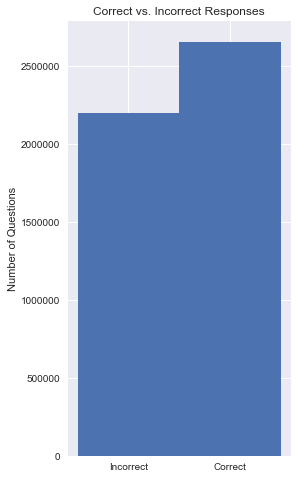

In [13]:
bins = (0,1,1,2)
fig, ax = plt.subplots(1,1, figsize=(4,8))
ax.hist(df_by_user_start.correct, bins=bins, align='left')
ax.set_xticks(bins[:-1])
plt.autoscale(enable=True, axis='both')

plt.title('Correct vs. Incorrect Responses')
plt.ylabel('Number of Questions')
ax.set_xticklabels(['Incorrect', 'Correct'])
plt.show() 

In [14]:
by_questionid = df.groupby('question_id')

user_count = by_questionid['question_id'].count()
question_ids = {'num_users': user_count}

df_question_id = pd.DataFrame(question_ids)
df_question_id.head() 

,num_users
question_id,
0,859
1,515
2,1318
3,813
4,407


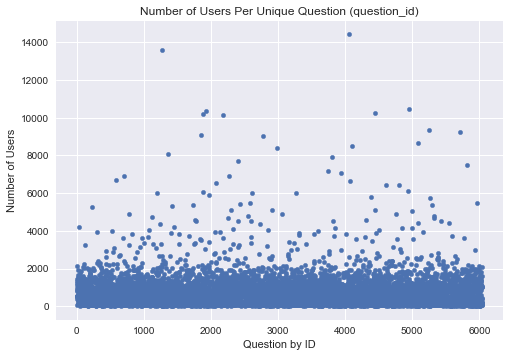

In [15]:
df_question_ids = pd.DataFrame({'Question by ID':df_question_id.index, 'Number of Users':user_count.values})

df_question_ids.plot(kind='scatter', x='Question by ID', y='Number of Users')
plt.title('Number of Users Per Unique Question (question_id)')
# plt.ylim(0,2000)
plt.show() 

<a id='question_type' href='#top'>back to menu</a>

### question_type
---

1. Frequency and distribution of these two categories?

In [16]:
question_types = df_by_user_start['question_type']
question_type_count = question_types.value_counts()
print(question_type_count) 

0    4666507
1     184968
Name: question_type, dtype: int64


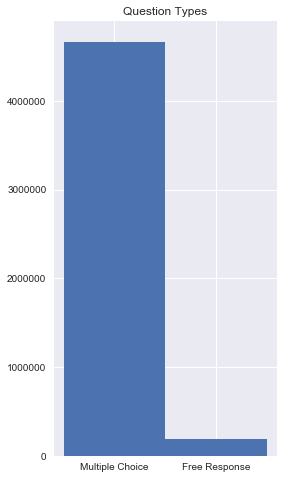

In [17]:
bins = (0,1,1,2)
fig, ax = plt.subplots(1,1, figsize=(4,8))
ax.hist(df_by_user_start.question_type, bins=bins, align='left')
ax.set_xticks(bins[:-1])
plt.autoscale(enable=True, axis='both')

plt.title('Question Types')
ax.set_xticklabels(['Multiple Choice', 'Free Response'])
plt.show() 

<a id='group_name' href='#top'>back to menu</a>

### group_name
---

1. Frequency and distribution of these categories?

<a id='track_name' href='#top'>back to menu</a>

### track_name
---

1. Frequency and distribution of these categories?

<a id='subtrack_name' href='#top'>back to menu</a>

### subtrack_name
---

<a id='tag_string' href='#top'>back to menu</a>

### tag_string
---

<a id='round_started_at' href='#top'>back to menu</a>

### round_started_at
---

[use this as reference date]

<a id='answered_at' href='#top'>back to menu</a>

### answered_at
---

[minutes from reference date]
1. What is the number of NULLs and the % of the total?

<a id='deactivated_at' href='#top'>back to menu</a>

### deactivated_at
---

[minutes from reference date]
1. Are there any NULLs?

<a id='game_type' href='#top'>back to menu</a>

### game_type
---

**`BookmarkGame: 0`** - values are like `ReviewGames`, but on specific questions the user has bookmarked.

**`ChallengeGame: 1`** - values are solo games where the user is taking a series of questions intended to challenge them and give them the best opportunities for learning.

**`CompetitiveGame: 2`** - values are the most different from other types of games. In these, once one user has answered correctly, the other users should be marked as 'skipped', and the game immediately proceeds to the next question. At the end of the game, whomever has answered the most questions correct wins.

**`ComputerAdaptiveTestGame: 3`** - values are the user answering questions on a full-length CAT, designed to mimic the algorithms used in the actual test, to ask them questions designed to maximize the information gain on the user's ability. TRYING TO IMPROVE THIS.

**`CustomGame: 4`** - values are normal games (like `PracticeGame`), but with some settings (such as specific areas or difficulty levels) chosen by the user.

**`DiagnosticGame: 5`** - values are solo games which are intended to give an initial rough assessment of the user's ability level.

**`NULL: 6`** - values represent a data collection failure.

**`PracticeGame: 7`** - is the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question.  Note that these can be solo games as well.

**`RecitationGame: 8`** - represents a game led by a tutor through a series of questions, with the tutor controlling the pace of advancement.

**`ReviewGame: 9`** - is a solo game (essentially a solo `PracticeGame`) started by a user to review questions they have played in the past.

**`StudyHallGame: 10`** - is the newest type of game: in these, users are answering their own series of questions as though the were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions.

**`StudyTaskGame: 11`** - is a game where the user is answering questions in a common skill area, in order to achieve a task in their personalized study plan.

In [18]:
print(Counter(df_by_user_start.game_type))

Counter({7: 3085722, 4: 831263, 5: 406752, 11: 275028, 3: 91745, 1: 72438, 2: 57916, 9: 21451, 0: 3994, 10: 2698, 8: 2081, 6: 387})


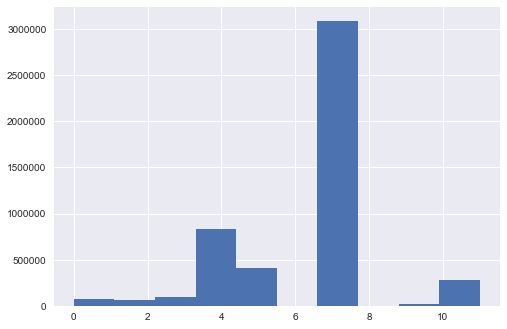

In [19]:
plt.hist(df_by_user_start.game_type)
plt.show()

In [ ]:
game_types = ['BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 'CustomGame', 'DiagnosticGame', 'NULL', 'PracticeGame', 'RecitationGame', 'ReviewGame', 'StudyHallGame', 'StudyTaskGame']

<a id='num_players' href='#top'>back to menu</a>

### num_players
---

1. Distribution of number of players per question?

<a id='date_of_test' href='#top'>back to menu</a>

### date_of_test
---

1. How many NULLs and % of the total?